In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import pysal as ps
import geopandas as gpd
import libpysal as lps
import sys
import platform
import zipfile
import os
from datetime import datetime
import time

import seaborn as sns
sns.set(style="darkgrid") # set style

print(sys.version_info)
print("Python Version: " + str(platform.python_version()))

/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
Python Version: 3.7.3


In [2]:
from  statsmodels.api import OLS
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from pysal.model import *
from pysal.explore.esda.moran import Moran
from scipy import stats
from pysal.lib.weights.weights import W
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [3]:
def analyze_preds_true(preds_y, true_y):
    """Code to analyze MSE, worst errors, plot residuals"""
    resids = preds_y - true_y
    print('Residual distribution:\n',stats.describe(resids))
    print('\nMSE:',mean_squared_error(true_y, preds_y))
    ## plot 1 is just pred vs true y
    sns.scatterplot(x=preds_y, y=true_y)
    plt.xlabel("Predictions")
    plt.ylabel("True")
    plt.title("Preds vs True")
    plt.show()
    ## plot 2 is redisuals
    sns.residplot(x=preds_y, y=resids,
                  lowess=True, 
                  scatter_kws={'alpha': 0.5}, 
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.title("Residual Plots")
    plt.show()

In [4]:
## create two train and test files, 
def create_train_test(data, cols, test_year, y_col = 'log_rate'):
    prev_year = test_year - 1
    X_train_all = data.query('year!=@test_year')[cols]
    y_train_all = data.query('year!=@test_year')[y_col]
    X_train_prevyear = data.query('year==@prev_year')[cols]
    y_train_prevyear = data.query('year==@prev_year')[y_col]
    
    X_test = data.query('year==@test_year')[cols]
    y_test = data.query('year==@test_year')[y_col]
    ## quick checks
    assert X_train_all.shape[0] == len(y_train_all) 
    assert X_train_prevyear.shape[0] == len(y_train_prevyear) 
    assert X_test.shape[0] == len(y_test) 
    assert X_train_all.shape[1] == len(cols) 
    print('There are %s training obs and %s test obs' % (len(y_train_all), len(y_test)))
    
    return(X_train_all, y_train_all, X_train_prevyear, y_train_prevyear, X_test, y_test)



In [5]:
def grid_search(model, param_search, scoring, X_train, Y_train, cv, refit='neg_mean_squared_error'):
    """Function for grid search and return best estimator
    Options:
    Regression
    ‘explained_variance’: metrics.explained_variance_score
    ‘neg_mean_absolute_error’: metrics.mean_absolute_error
    ‘neg_mean_squared_error’: metrics.mean_squared_error
    ‘neg_mean_squared_log_error’: metrics.mean_squared_log_error
    ‘neg_median_absolute_error’: metrics.median_absolute_error
    ‘r2’: metrics.r2_score

    """
    grid = GridSearchCV(estimator=model, cv=cv,
                        param_grid=param_search, scoring = scoring,
                        refit=refit, return_train_score=True, verbose=1) # metric b/c balanced data set

    gs = grid.fit(X_train, Y_train)
    best_model = gs.best_estimator_ # based on roc_auc score
    return(gs, best_model)

## Create Data
Add Malvika's data to ALL census vars

In [6]:
malvika_url = "https://raw.githubusercontent.com/malvikarajeev/sfcrimeanalysis/master/weekly_crime_counts_with_varaibles.csv"
addtl_data = pd.read_csv(malvika_url, index_col=0)
addtl_data['GEOID'] = [str(g).rjust(11, '0') for g in addtl_data['GEOID']]
addtl_data.head(5)

,year,GEOID,week,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
1,2010,06075010100,1,34,4,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
2,2010,06075010100,2,29,9,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
3,2010,06075010100,3,21,6,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
4,2010,06075010100,4,21,15,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472
5,2010,06075010100,5,22,6,3744,0.337502,0.48531,0.936699,0.795406,0.080802,0.199252,565,1564.1202,528.96,0.503472


In [7]:
yearly_agg_data = addtl_data[['year','GEOID','N','N_calls_311']].groupby(['year','GEOID']).sum().reset_index()
yearly_agg_data.head(5)

,year,GEOID,N,N_calls_311
0,2010,06075010100,1604,600
1,2010,06075010200,823,634
2,2010,06075010300,234,445
3,2010,06075010400,289,599
4,2010,06075010500,1096,663


In [8]:
census_vars = addtl_data.drop(['week','N','N_calls_311'], axis=1).groupby(['year','GEOID']).mean().reset_index()
census_vars.head(5)

,year,GEOID,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
0,2010,06075010100,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472
1,2010,06075010200,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294
2,2010,06075010300,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169
3,2010,06075010400,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725
4,2010,06075010500,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299


In [9]:
yearly_data2 = yearly_agg_data.merge(census_vars, left_on=['year','GEOID'], right_on=['year','GEOID'], how='inner')
yearly_data2.head(5)

,year,GEOID,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class
0,2010,06075010100,1604,600,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472
1,2010,06075010200,823,634,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294
2,2010,06075010300,234,445,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169
3,2010,06075010400,289,599,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725
4,2010,06075010500,1096,663,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299


In [10]:
yearly_data2['rate'] = yearly_data2['N'] / yearly_data2['Estimate_Total']
yearly_data2['log_count'] = np.log(yearly_data2['N'])
yearly_data2['log_rate'] = np.log(yearly_data2['rate'])
yearly_data2.head(5)

,year,GEOID,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,prop_stable,racial_index,income_index,age_index,working_class,rate,log_count,log_rate
0,2010,06075010100,1604,600,3744,0.337502,0.485310,0.936699,0.795406,0.080802,0.199252,565,1564.120200,528.96,0.503472,0.428419,7.380256,-0.847654
1,2010,06075010200,823,634,4184,0.362643,0.473948,0.885038,0.950765,0.438360,0.173757,444,2667.206779,747.13,0.352294,0.196702,6.712956,-1.626067
2,2010,06075010300,234,445,4285,0.354192,0.501750,0.944457,0.808401,0.213598,0.275613,109,1868.883223,648.90,0.415169,0.054609,5.455321,-2.907555
3,2010,06075010400,289,599,4154,0.377667,0.469186,0.931873,0.949446,0.315683,0.206548,122,2640.336721,750.38,0.422725,0.069571,5.666427,-2.665400
4,2010,06075010500,1096,663,2429,0.378550,0.500206,0.942775,0.940716,0.286248,0.217373,45,1513.915619,458.53,0.306299,0.451214,6.999422,-0.795812


In [11]:
census_files = '../../data/census_tract_2009_2017.csv'
census_data = pd.read_csv(census_files, dtype={'GEOID':'str', 'year': 'int'})
census_data['GEOID'] = [g.rjust(11, '0') for g in census_data['GEOID']]
census_data.head(5)

,GEOID,NAME,year,Estimate_Total,Female,Female_10_to_14_years,Female_10th_grade,Female_11th_grade,Female_12th_grade_no_diploma,Female_15_to_17_years,...,Same_house_1_year_ago_Male,With_income,With_income_1_to_9999_or_loss,With_income_10000_to_14999,With_income_15000_to_24999,With_income_25000_to_34999,With_income_35000_to_49999,With_income_50000_to_64999,With_income_65000_to_74999,With_income_75000_or_more
0,06075010100,"Census Tract 101, San Francisco County, Califo...",2009,3685.0,1737.0,46,42,13,17,65,...,1500.0,2963.0,504,296,356.0,167,547,395,92,606.0
1,06075010100,"Census Tract 101, San Francisco County, Califo...",2010,3744.0,1927.0,40,34,14,10,61,...,1464.0,3117.0,496,354,342.0,131,562,351,231,650.0
2,06075010100,"Census Tract 101, San Francisco County, Califo...",2011,3851.0,1890.0,60,0,13,20,86,...,1567.0,3172.0,410,383,506.0,149,437,413,205,669.0
3,06075010100,"Census Tract 101, San Francisco County, Califo...",2012,3598.0,1662.0,28,0,0,17,39,...,1430.0,3008.0,392,407,425.0,175,365,337,162,745.0
4,06075010100,"Census Tract 101, San Francisco County, Califo...",2013,3741.0,1690.0,27,0,0,12,14,...,1367.0,3127.0,340,380,498.0,190,364,309,172,874.0


In [12]:
all_data = yearly_data2.merge( census_data.drop(['Estimate_Total'],axis=1), how='left', left_on=['GEOID', 'year'], right_on=['GEOID', 'year'])
all_data = all_data[np.isfinite(all_data['log_rate'])] # keep rows where log_rate isnt NA
all_data = all_data.fillna(0) # now fill all other columns with 0 
print(all_data.shape)
all_data.head(5)

(1560, 166)


,year,GEOID,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,prop_vacant_houses,...,Same_house_1_year_ago_Male,With_income,With_income_1_to_9999_or_loss,With_income_10000_to_14999,With_income_15000_to_24999,With_income_25000_to_34999,With_income_35000_to_49999,With_income_50000_to_64999,With_income_65000_to_74999,With_income_75000_or_more
0,2010,06075010100,1604,600,3744,0.337502,0.485310,0.936699,0.795406,0.080802,...,1464.0,3117.0,496,354,342.0,131,562,351,231,650.0
1,2010,06075010200,823,634,4184,0.362643,0.473948,0.885038,0.950765,0.438360,...,1631.0,3659.0,239,172,222.0,446,395,322,232,1631.0
2,2010,06075010300,234,445,4285,0.354192,0.501750,0.944457,0.808401,0.213598,...,1474.0,3448.0,488,231,317.0,233,510,375,133,1161.0
3,2010,06075010400,289,599,4154,0.377667,0.469186,0.931873,0.949446,0.315683,...,1501.0,3737.0,369,172,405.0,259,551,659,157,1165.0
4,2010,06075010500,1096,663,2429,0.378550,0.500206,0.942775,0.940716,0.286248,...,947.0,2255.0,160,235,209.0,61,79,187,78,1246.0


In [13]:
shapefile0 = gpd.read_file("tl_2010_06_tract10/tl_2010_06_tract10.shp")
shapefile = shapefile0.query("COUNTYFP10=='075' and ALAND10>0") # grab tracts with land 
shapefile.index = list(range(shapefile.shape[0])) # GEOID10 is match with R 
shapefile.head(5)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,06,075,016500,06075016500,165,Census Tract 165,G5020,S,370459,0,+37.7741958,-122.4477884,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,06,075,016400,06075016400,164,Census Tract 164,G5020,S,309097,0,+37.7750995,-122.4369729,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,06,075,016300,06075016300,163,Census Tract 163,G5020,S,245867,0,+37.7760456,-122.4295509,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,06,075,016100,06075016100,161,Census Tract 161,G5020,S,368901,0,+37.7799831,-122.4286631,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,06,075,016000,06075016000,160,Census Tract 160,G5020,S,158236,0,+37.7823363,-122.4224838,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


In [14]:
spatial_census = pd.merge(shapefile, all_data, left_on='GEOID10', right_on='GEOID', how='inner')
spatial_census = spatial_census.select_dtypes(exclude='object')
spatial_census.head(5)

,ALAND10,AWATER10,year,N,N_calls_311,Estimate_Total,prop_rented,prop_male,prop_african_american,prop_under_poverty_level,...,Same_house_1_year_ago_Male,With_income,With_income_1_to_9999_or_loss,With_income_10000_to_14999,With_income_15000_to_24999,With_income_25000_to_34999,With_income_35000_to_49999,With_income_50000_to_64999,With_income_65000_to_74999,With_income_75000_or_more
0,370459,0,2010,630,900,4812,0.355994,0.487323,0.860973,0.892645,...,1840.0,4254.0,541,398,515.0,404,550,491,254,1101.0
1,370459,0,2011,619,1123,5098,0.345560,0.484504,0.883288,0.866613,...,1888.0,4443.0,661,454,424.0,496,452,339,342,1275.0
2,370459,0,2012,665,1239,5166,0.343240,0.500387,0.873209,0.838458,...,2136.0,4549.0,770,499,455.0,401,442,431,340,1211.0
3,370459,0,2013,871,1225,5289,0.340747,0.477973,0.883343,0.850349,...,2018.0,4581.0,640,451,397.0,467,538,498,306,1284.0
4,370459,0,2014,850,1463,5787,0.337359,0.463453,0.850527,0.864932,...,2316.0,4995.0,906,554,425.0,435,499,499,255,1422.0


In [15]:
x_cols = [c for c in list(spatial_census) if c not in ['rate','log_rate', 'N', 'log_count']]
print(x_cols)
X_train_all, y_train_all, X_train2016, y_train2016, X_test, y_test = create_train_test(spatial_census,
                                                                                       cols=x_cols,
                                                                                       test_year=2017)

['ALAND10', 'AWATER10', 'year', 'N_calls_311', 'Estimate_Total', 'prop_rented', 'prop_male', 'prop_african_american', 'prop_under_poverty_level', 'prop_vacant_houses', 'prop_stable', 'racial_index', 'income_index', 'age_index', 'working_class', 'Female', 'Female_10_to_14_years', 'Female_10th_grade', 'Female_11th_grade', 'Female_12th_grade_no_diploma', 'Female_15_to_17_years', 'Female_18_and_19_years', 'Female_20_years', 'Female_21_years', 'Female_22_to_24_years', 'Female_25_to_29_years', 'Female_30_to_34_years', 'Female_35_to_39_years', 'Female_40_to_44_years', 'Female_45_to_49_years', 'Female_5_to_9_years', 'Female_50_to_54_years', 'Female_55_to_59_years', 'Female_5th_and_6th_grade', 'Female_60_and_61_years', 'Female_62_to_64_years', 'Female_65_and_66_years', 'Female_67_to_69_years', 'Female_70_to_74_years', 'Female_75_to_79_years', 'Female_7th_and_8th_grade', 'Female_80_to_84_years', 'Female_85_years_and_over', 'Female_9th_grade', "Female_Associate's_degree", "Female_Bachelor's_degre

#### Create Customer CV Splits
Because our data is time series, we can't use a normal cross validation. Therefore we need to pick priors. The code below gets indices to create 5 splits where each split is:

* train: 2010; test: 2011
* train: 2010, 2011; test: 2012
* train: 2010, 2011, 2012; test: 2013
* train: 2010, 2011, 2012, 2013; test: 2014
* train: 2010, 2011, 2012, 2013, 2014; test: 2015
* train: 2010, 2011, 2012, 2013, 2014, 2015; test: 2016


In [16]:
groups = yearly_data2.query('year!=2017').groupby(yearly_data2.query('year!=2017')['year']).groups
#groups[2010].values
# {2012: [0, 1], 2013: [2], 2014: [3], 2015: [4, 5]}
sorted_groups = [list(indices.values) for (key, indices) in sorted(groups.items())] 
# # [[0, 1], [2], [3], [4, 5]]
#sorted_groups
cv = [(np.array(sum( sorted_groups[:(i-1)], [])), np.array(sorted_groups[i]))
      for i in range(len(sorted_groups)-1,1,-1)]

scoring = 'neg_mean_squared_error'

## Modeling with all years
1. RF
2. Lasso

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.6min finished


Residual distribution:
 DescribeResult(nobs=195, minmax=(-0.9903745257685084, 1.4029505589196174), mean=0.09359256622569817, variance=0.15798111928679678, skewness=0.24287720505718, kurtosis=0.7869244681353789)

MSE: 0.16593052815342235


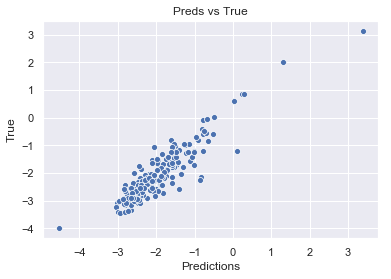

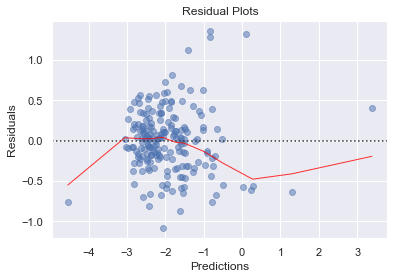

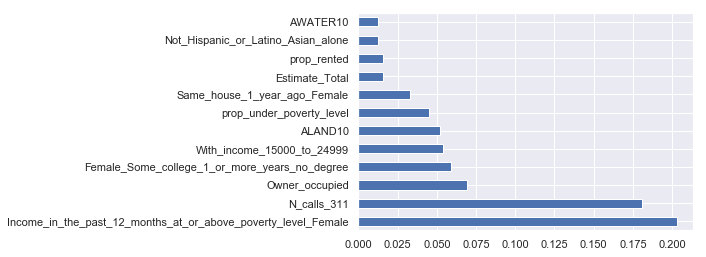

In [17]:
rf_tree = RandomForestRegressor(random_state=0) 
param_search_rf = {'max_depth' : [None, 2, 3, 5, 10],
                   'n_estimators': [10, 50, 100, 200 ]}

grid_rf, best_rf = grid_search(model=rf_tree, param_search=param_search_rf, scoring=scoring,
                               X_train=X_train_all, Y_train = y_train_all, cv=cv, refit='neg_mean_squared_error')
best_rf.fit(X_train_all, y_train_all)  

y_pred_rf = best_rf.predict(X_test)

analyze_preds_true(y_pred_rf, y_test)  # for model


feat_importances = pd.Series(best_rf.feature_importances_, index=x_cols)
feat_importances.nlargest(12).plot(kind='barh')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.4s finished


Residual distribution:
 DescribeResult(nobs=195, minmax=(-0.9475135144579978, 1.593642851232892), mean=0.13344343070437023, variance=0.14230250302025088, skewness=0.27941294089858476, kurtosis=1.5458804717819081)

MSE: 0.15937989579265807


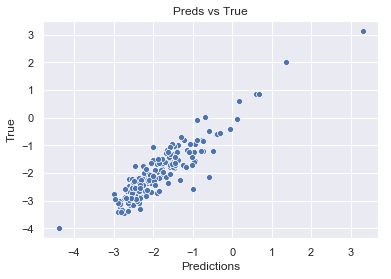

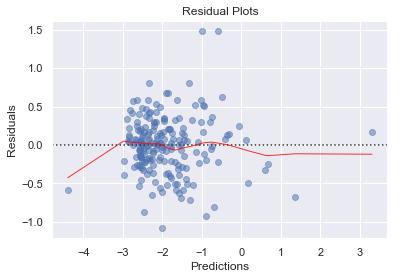

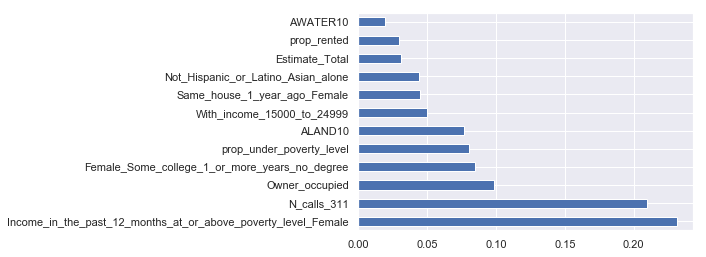

In [33]:
subset_of_feats = feat_importances.nlargest(12).index.values
X_train_subset = X_train_all[subset_of_feats]

rf_tree_subset = RandomForestRegressor(random_state=0) 
param_search_rf = {'max_depth' : [None, 2, 3, 5, 10],
                   'n_estimators': [10, 50, 100, 200 ]}

grid_rf_subset, best_rf_subset = grid_search(model=rf_tree_subset, param_search=param_search_rf, scoring=scoring,
                               X_train=X_train_subset, Y_train = y_train_all, cv=cv, refit='neg_mean_squared_error')
best_rf_subset.fit(X_train_subset, y_train_all)  

y_pred_rf_subset = best_rf_subset.predict(X_test[subset_of_feats])

analyze_preds_true(y_pred_rf_subset, y_test)  # for model


feat_importances = pd.Series(best_rf_subset.feature_importances_, index=subset_of_feats)
feat_importances.nlargest(12).plot(kind='barh')

## LASSO Regresssion
1. Scale X and Y
2. Run Lasso CV
3. Pick lowest train alpha
4. Create LASSO with best alpha
5. Test

In [18]:
X_scaler = StandardScaler()
X_scaler.fit(X_train_all)
X_train_scale = X_scaler.transform(X_train_all)
X_test_scale = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_scaler.fit(np.array(y_train_all ).reshape(-1,1))
y_train_scale = y_scaler.transform(np.array(y_train_all ).reshape(-1,1) )
y_test_scale = y_scaler.transform(np.array(y_test).reshape(-1,1))
print(X_train_scale.shape, X_train_all.shape, y_train_scale.shape)

(1365, 162) (1365, 162) (1365, 1)


/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


Computing regularization path using the coordinate descent lasso...


/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/andreabonilla/Cal/Spring2019/Stat222/crime_env/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/andreabonilla/Cal/Spring2019/Stat222/cr

Alpha to choose is  0.1046109301024041


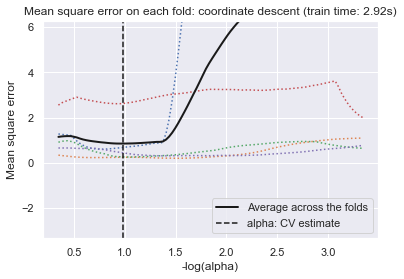

In [22]:
# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
lasso_cv = LassoCV(cv=cv, max_iter=10000).fit(X_train_scale, y_train_scale.reshape(1365))
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(lasso_cv.alphas_)

plt.figure()
ymin, ymax = np.min(y_train_scale), np.max(y_train_scale)
plt.plot(m_log_alphas, lasso_cv.mse_path_, ':')
plt.plot(m_log_alphas, lasso_cv.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(lasso_cv.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

best_alpha = lasso_cv.alphas_[np.argmin(lasso_cv.mse_path_.mean(axis=-1))]

print('Alpha to choose is ', best_alpha)

ALAND10 has coef 0.01631219484246185
N_calls_311 has coef 0.3208331665820389
prop_rented has coef 0.004753939427078941
prop_male has coef 0.12688614800558856
prop_under_poverty_level has coef -0.039720239842352185
prop_vacant_houses has coef -0.05356421601624918
prop_stable has coef 0.06029582937489812
income_index has coef -0.25148922087803366
Income_in_the_past_12_months_below_poverty_level_Male_Not_in_labor_force has coef 0.0018164397970676857
Not_Hispanic_or_Latino_Black_or_African_American_alone has coef 0.00884965222994389
With_income_50000_to_64999 has coef -0.01782909877583771
With_income_65000_to_74999 has coef -0.04100774951622344


Residual distribution:
 DescribeResult(nobs=195, minmax=(-3.6105715550643946, 1.8244350607101694), mean=0.2141154570437405, variance=0.3550381338363418, skewness=-1.627952170528697, kurtosis=8.944806120515818)

MSE: 0.39906285440274375


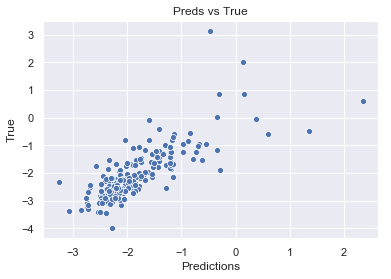

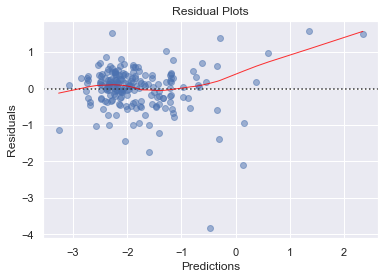

In [23]:
best_lasso = Lasso(alpha=best_alpha).fit(X_train_scale, y_train_scale)
for c, col in zip(best_lasso.coef_, x_cols):
    if c!=0:
        print("%s has coef %s" % (col, c))
print('\n')
best_lasso_pred = y_scaler.inverse_transform(best_lasso.predict(X_test_scale))
analyze_preds_true(best_lasso_pred, y_test)